# Script to Count Word Frequency and Plot

## Load Into DataFrame

In [45]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

# Set name of file
filename = '../data/interim/summaries.csv'

# Read to DataFrame
df = pd.read_csv(filename, sep=',', header=[0], error_bad_lines=False)
df.head()

,Id,Accession,title,summary,taxon
0,200112120,GSE112120,Risk SNPs mediated promoter-enhancer switching...,To determine the binding of H3K4me1 and H3K4me...,Homo sapiens
1,200117735,GSE117735,The ATPase module of mammalian SWI/SNF family ...,This SuperSeries is composed of the SubSeries ...,Homo sapiens
2,200117734,GSE117734,The mSWI/SNF ATPase module mediates subcomplex...,Perturbations to mammalian SWI/SNF (mSWI/SNF) ...,Homo sapiens
3,200128119,GSE128119,COX-2 mediates tumor-stromal Prolactin signali...,Tumor-stromal communication within the microen...,Homo sapiens
4,200126367,GSE126367,Copy number analysis of selumetinib-resistant ...,Copy number analysis to compare parental color...,Homo sapiens


# Get the Data

In [2]:
messages = pd.DataFrame(df['summary'])
messages['length'] = messages['summary'].apply(len)
messages.head()

,summary,length
0,To determine the binding of H3K4me1 and H3K4me...,102
1,This SuperSeries is composed of the SubSeries ...,59
2,Perturbations to mammalian SWI/SNF (mSWI/SNF) ...,1429
3,Tumor-stromal communication within the microen...,1167
4,Copy number analysis to compare parental color...,180


# Exploratory Data Analysis

In [3]:
messages.describe()

,length
count,100.000000
mean,676.230000
std,601.822465
min,28.000000
25%,179.250000
50%,412.000000
75%,1103.750000
max,2495.000000


In [4]:
print('Shortest Message:---\n',messages[messages['length'] == 28]['summary'].iloc[0])
print('\n')
print('Longest  Message:---\n',messages[messages['length'] == 2495]['summary'].iloc[0])

Shortest Message:---
 MLLT3 binds to open gene TSS


Longest  Message:---
 Comparison af adherent growing breast cancer cell lines versus mammospheres under serum-free conditions Background: In patients with breast cancer, subsets of long-lived cells tolerate chemotherapies. These chemoresistant cells can remain dormant at secondary sites, such as bone and lung, for years and decades. Cancer cells endowed with drug resistance are maintained in vivo in a quiescent slow-growing state that preserves them from anti-proliferative cancer drugs. The mechanism of conversion from dormancy to growth remains poorly understood. We aimed to identify microRNAs (miRNAs) as master regulators of cancer stem cells (CSCs) maintainance, because one of the characteristics of CSCs is their slow proliferation or dormancy. MiRNA targeting CSCs may be an effective therapy to improve the prognosis of breast cancer patients. Methods: We performed miRNA array analysis to identify differences miRNA expression prof

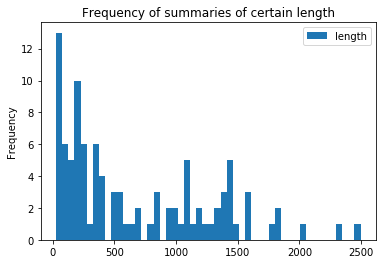

In [5]:
messages.groupby('length').count()
messages['length'].plot(bins=50, kind='hist', title='Frequency of summaries of certain length', legend=True) 

# Text Pre-Processing

In [6]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [7]:
messages['summary'].head(5).apply(text_process)

0    [determine, binding, H3K4me1, H3K4me3, PCAT19,...
1           [SuperSeries, composed, SubSeries, listed]
2    [Perturbations, mammalian, SWISNF, mSWISNF, ch...
3    [Tumorstromal, communication, within, microenv...
4    [Copy, number, analysis, compare, parental, co...
Name: summary, dtype: object

# Stemming (?)

# Vectorization

In [8]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['summary'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

2402


In [9]:
message2 = messages['summary'][1]
bow2 = bow_transformer.transform([message2])
print(bow2)
print()
print(bow2.shape)

  (0, 478)	1
  (0, 479)	1
  (0, 834)	1
  (0, 1446)	1

(1, 2402)


In [10]:
print(message2)
print(bow_transformer.get_feature_names()[478])
print(bow_transformer.get_feature_names()[479])
print(bow_transformer.get_feature_names()[834])
print(bow_transformer.get_feature_names()[1446])

This SuperSeries is composed of the SubSeries listed below.
SubSeries
SuperSeries
composed
listed


In [11]:
messages_bow = bow_transformer.transform(messages['summary'])

In [12]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)
print('Sparsity: {:5.3f}%'.format(sparsity))

Shape of Sparse Matrix:  (100, 2402)
Amount of Non-Zero occurences:  4980
Sparsity: 2.073%


# TD-IDF

In [13]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf2 = tfidf_transformer.transform(bow2)
print(tfidf2)

  (0, 1446)	0.5
  (0, 834)	0.5
  (0, 479)	0.5
  (0, 478)	0.5


In [14]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['cancer']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['breast']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['study']])

2.2829160066660554
3.41789593950504
2.1811333123561134


In [15]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)
print(messages_tfidf[0])

(100, 2402)
  (0, 1765)	0.21153837184873148
  (0, 1454)	0.3028393912162638
  (0, 963)	0.26237810100786624
  (0, 758)	0.15874815089931932
  (0, 687)	0.3172806507723162
  (0, 393)	0.3898578737868942
  (0, 258)	0.3349553240224442
  (0, 257)	0.3898578737868942
  (0, 162)	0.3172806507723162
  (0, 28)	0.3898578737868942


# Training the model (K-means Clustering)

In [25]:
X = messages_tfidf
print(X.shape)
print(X.transpose().shape)

(100, 2402)
(2402, 100)


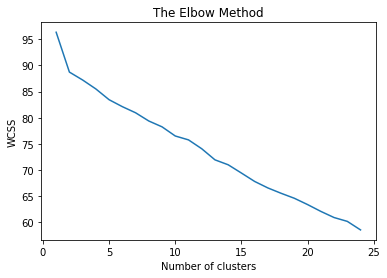

In [26]:
wcss = []
max_elbow = 25
for i in range(1, max_elbow):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, max_elbow), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [27]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [28]:
from scipy.sparse import csr_matrix
X=X.toarray()

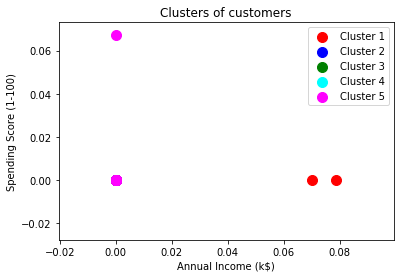

In [32]:
# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 50, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

# Training the model (Hierarchical Clustering)

In [43]:
X = messages_tfidf.toarray()
print(X.shape)
print(X.transpose().shape)

(100, 2402)
(2402, 100)


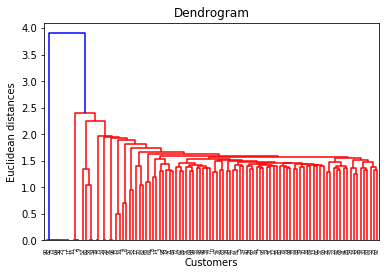

In [44]:
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [46]:
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

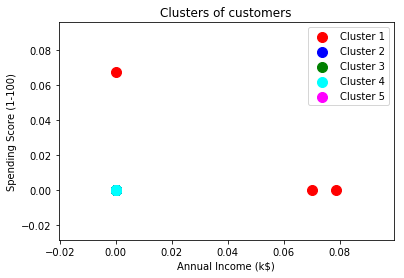

In [47]:
# Visualising the clusters
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()